In [1]:
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import numpy as np
import librosa
from utils.strechableNumpyArray import StrechableNumpyArray
import matplotlib.pyplot as plt
import IPython
import functools
from tensorflow.contrib.signal.python.ops import window_ops

In [2]:
import pickle

from architecture.contextEncoderArchitecture import ContextEncoderArchitecture
from system.contextEncoderSystem import ContextEncoderSystem
from system.preAndPostProcessor import PreAndPostProcessor
from system.magPreAndPostProcessor import MagPreAndPostProcessor

In [3]:
def _pavlovs_SNR(y_orig, y_inp, onAxis=(1,)):
    norm_y_orig = _squaredEuclideanNorm(y_orig, onAxis)
    norm_y_orig_minus_y_inp = _squaredEuclideanNorm(y_orig - y_inp, onAxis)
    return 10 * np.log10(norm_y_orig / norm_y_orig_minus_y_inp)

def _squaredEuclideanNorm(vector, onAxis=(1,)):
    squared = np.square(vector)
    summed = np.sum(squared, axis=onAxis)
    return summed

In [4]:
def generate_fake_audio(window_size, fs):
    fake_audio = StrechableNumpyArray()
    phase_shifts = [phase_shift*np.pi for phase_shift in np.arange(0,2,0.2)]
    
    discrete_time =  np.arange(0, window_size/fs, 1/fs)
    for freq in np.logspace(1.3,3.9,800):
        for phase_shift in phase_shifts:
            signal = 0.1 * np.sin(2 * np.pi * freq * discrete_time + phase_shift)
            fake_audio.append(signal)
    fake_audio = fake_audio.finalize()
    return np.reshape(fake_audio, [-1, window_size])
    
fake_audio = generate_fake_audio(5120, 16000)

print(fake_audio.shape)

(8000, 5120)


In [5]:
sr = 16000
start_in_seconds = 0.1
gap_length = 1024
side_length = 2048

starting_sample_left_side = int(sr*start_in_seconds)
ending_sample_left_side = starting_sample_left_side + side_length
starting_sample_right_side = ending_sample_left_side + gap_length
ending_sample_right_side = starting_sample_right_side + side_length

# best_step = 967467
# best_step = 723261
# best_step = 2491124
# best_step = 2567124
# best_step = 1116132 

batch_size = 256

In [11]:
tf.reset_default_graph()

architecturesParametersFile = "Papers_Context_Encoder_parameters.pkl"
sessionsName = "Papers_Context_Encoder"

with open(architecturesParametersFile, 'rb') as savedFile:
    Context_Encoder_parameters = pickle.load(savedFile)

aContextEncoderArchitecture = ContextEncoderArchitecture(*Context_Encoder_parameters.architectureParameters())
aPreProcessor = PreAndPostProcessor(*Context_Encoder_parameters.preProcessorParameters())
aContextEncoderSystem = ContextEncoderSystem(aContextEncoderArchitecture, Context_Encoder_parameters.batchSize(),
                                             aPreProcessor, sessionsName)
generatedSpecs = aContextEncoderSystem.reconstructAudio(fake_audio, model_num=967467)

---------
Encoder
---------
Tensor("ContextEncoderArchitecture/input_data:0", shape=(256, 16, 257, 4), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_0/Conv2D:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization/cond/Merge:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_1/Conv2D:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_1:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization_2/cond/Merge:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_2/Conv2D:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_2:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalizatio

In [12]:
complexGenerated = generatedSpecs[0][:, :, :, 0] + 1.0j * generatedSpecs[0][:, :, :, 1]
complexOriginal = generatedSpecs[1][:, :, :, 0] + 1.0j * generatedSpecs[1][:, :, :, 1]
complexContext = np.concatenate([generatedSpecs[2][:, :, :, 0] + 1.0j * generatedSpecs[2][:, :, :, 1],
                                 generatedSpecs[2][:, :, :, 2] + 1.0j * generatedSpecs[2][:, :, :, 3]],
                                axis=1)

print(complexContext.shape)
print(complexGenerated.shape)
print(generatedSpecs[0].shape)
print(np.mean(_pavlovs_SNR(np.abs(generatedSpecs[1]), np.abs(generatedSpecs[0]), onAxis=(1, 2, 3))))
complexTotal =  np.concatenate([generatedSpecs[2][:, :13, :, 0] + 1.0j * generatedSpecs[2][:, :13, :, 1], complexGenerated,
                                 generatedSpecs[2][:, 3:, :, 2] + 1.0j * generatedSpecs[2][:, 3:, :, 3]],
                                axis=1)

(7936, 32, 257)
(7936, 11, 257)
(7936, 11, 257, 2)
19.222963


In [8]:
tf.reset_default_graph()

architecturesParametersFile = "Papers_Context_Encoder_parameters.pkl"
sessionsName = "Papers_FMA_Context_Encoder"

with open(architecturesParametersFile, 'rb') as savedFile:
    Context_Encoder_parameters = pickle.load(savedFile)

aContextEncoderArchitecture = ContextEncoderArchitecture(*Context_Encoder_parameters.architectureParameters())
aPreProcessor = PreAndPostProcessor(*Context_Encoder_parameters.preProcessorParameters())
aContextEncoderSystem = ContextEncoderSystem(aContextEncoderArchitecture, Context_Encoder_parameters.batchSize(),
                                             aPreProcessor, sessionsName)
generatedSpecs = aContextEncoderSystem.reconstructAudio(fake_audio, model_num=2567124)

---------
Encoder
---------
Tensor("ContextEncoderArchitecture/input_data:0", shape=(256, 16, 257, 4), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_0/Conv2D:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization/cond/Merge:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_1/Conv2D:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_1:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization_2/cond/Merge:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_2/Conv2D:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_2:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalizatio

In [10]:
complexGeneratedFMA = generatedSpecs[0][:, :, :, 0] + 1.0j * generatedSpecs[0][:, :, :, 1]
complexOriginal = generatedSpecs[1][:, :, :, 0] + 1.0j * generatedSpecs[1][:, :, :, 1]
complexContext = np.concatenate([generatedSpecs[2][:, :, :, 0] + 1.0j * generatedSpecs[2][:, :, :, 1],
                                 generatedSpecs[2][:, :, :, 2] + 1.0j * generatedSpecs[2][:, :, :, 3]],
                                axis=1)

print(complexContext.shape)
print(complexGenerated.shape)
print(generatedSpecs[0].shape)
print(np.mean(_pavlovs_SNR(np.abs(generatedSpecs[1]), np.abs(generatedSpecs[0]), onAxis=(1, 2, 3))))
complexTotalFMA =  np.concatenate([generatedSpecs[2][:, :13, :, 0] + 1.0j * generatedSpecs[2][:, :13, :, 1], complexGeneratedFMA,
                                 generatedSpecs[2][:, 3:, :, 2] + 1.0j * generatedSpecs[2][:, 3:, :, 3]],
                                axis=1)

(7936, 32, 257)
(7936, 11, 257)
(7936, 11, 257, 2)
12.59036


In [14]:
FMASNRs = _pavlovs_SNR(np.abs(complexOriginal), np.abs(complexGeneratedFMA), onAxis=(1, 2))
NSSNRs = _pavlovs_SNR(np.abs(complexOriginal), np.abs(complexGenerated), onAxis=(1, 2))

print(NSSNRs.shape)
print(FMASNRs.mean())
print(NSSNRs.mean())

(7936,)
13.655911
21.55829


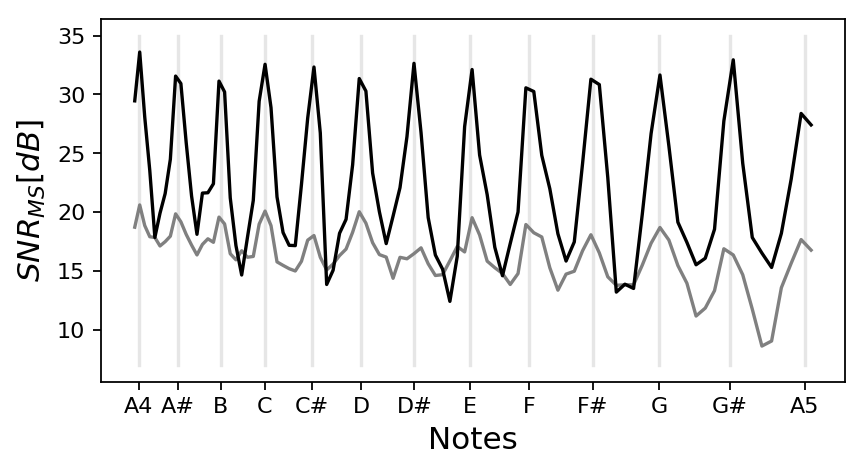

In [39]:
freq = np.logspace(1.3,3.9,800)[:793]
FMAmeans = np.mean(np.reshape(FMASNRs[:7930], (-1, 10)), axis=1)
NSmeans = np.mean(np.reshape(NSSNRs[:7930], (-1, 10)), axis=1)

freq_ticks = [440, 466, 493.88, 523, 554.4, 587, 622, 659, 698, 740, 784, 830.6, 880]

plt.figure(num=None, figsize=(6, 3), dpi=160, facecolor='w', edgecolor='k')
plt.ylabel(r'$SNR_{MS} [dB]$', fontsize=14)
plt.xlabel('Notes', fontsize=14)
plt.xticks([440, 466, 493.88, 523, 554.4, 587, 622, 659, 698, 740, 784, 830.6, 880], 
           ['A4', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A5'])
# plt.ylim((7, 34))

for freqs in freq_ticks:
    plt.plot([freqs]*2, [7, 35], color='#e6e6e6')
plt.plot(freq[412:507], FMAmeans[412:507], color='gray');
plt.plot(freq[412:507], NSmeans[412:507], color='black');

plt.savefig('freq_resolution_comp.pdf', bbox_inches='tight')


In [42]:
tf.reset_default_graph()

architecturesParametersFile = "Papers_Mag_Context_Encoder_parameters.pkl"
sessionsName = "Papers_Mag_Context_Encoder"

with open(architecturesParametersFile, 'rb') as savedFile:
    Context_Encoder_parameters = pickle.load(savedFile)

aContextEncoderArchitecture = ContextEncoderArchitecture(*Context_Encoder_parameters.architectureParameters())
aPreProcessor = MagPreAndPostProcessor(*Context_Encoder_parameters.preProcessorParameters())
aContextEncoderSystem = ContextEncoderSystem(aContextEncoderArchitecture, Context_Encoder_parameters.batchSize(),
                                             aPreProcessor, sessionsName)
generatedSpecs = aContextEncoderSystem.reconstructAudio(fake_audio, model_num=1116132)

---------
Encoder
---------
Tensor("ContextEncoderArchitecture/input_data:0", shape=(256, 16, 257, 4), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_0/Conv2D:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization/cond/Merge:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_1/Conv2D:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_1:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization_2/cond/Merge:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_2/Conv2D:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_2:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalizatio

In [48]:
generatedMag = generatedSpecs[0][:, :, :, 0] 

In [49]:
NSMAGSNRs = _pavlovs_SNR(np.abs(complexOriginal), generatedMag, onAxis=(1, 2))

print(NSSNRs.shape)
print(NSMAGSNRs.mean())
print(NSSNRs.mean())

(7936,)
29.276955
21.55829


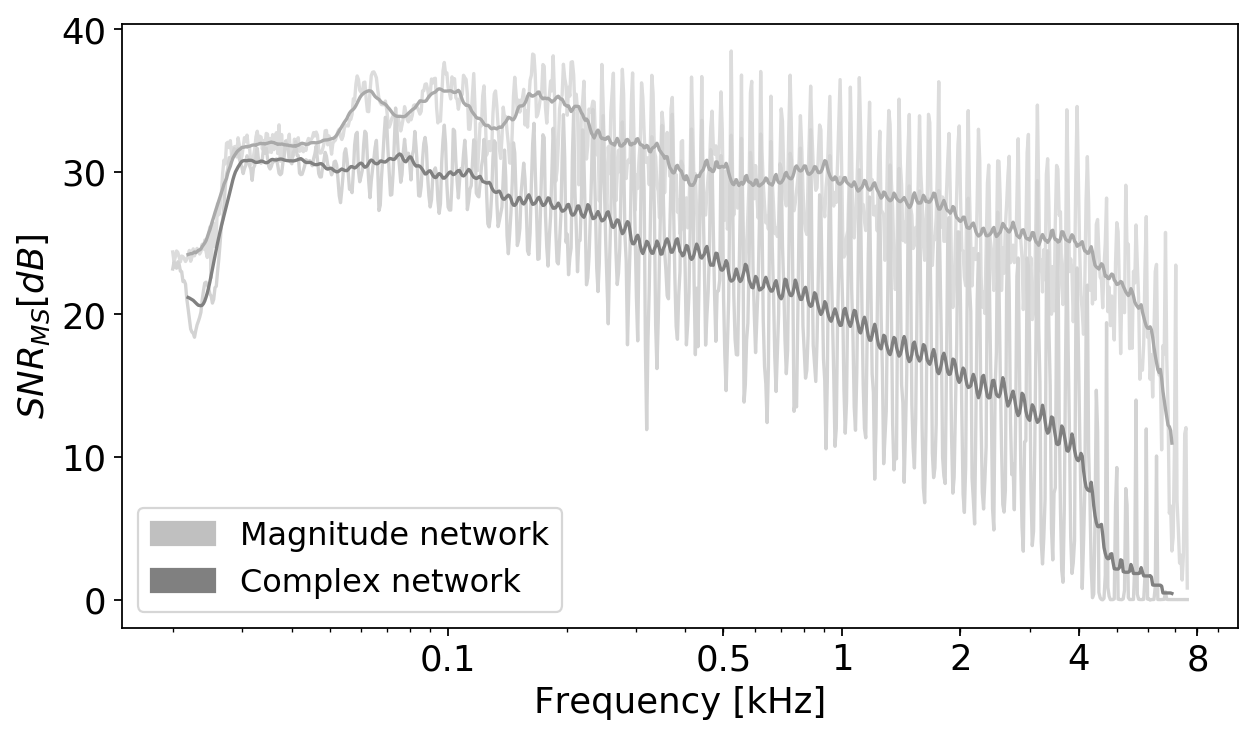

In [56]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

freq = np.logspace(1.3,3.9,800)[:793]
meansNSynthComplex = np.mean(np.reshape(NSSNRs[:7930], (-1, 10)), axis=1)
meansNSynthMag = np.mean(np.reshape(NSMAGSNRs[:7930], (-1, 10)), axis=1)

freq_ticks = [440, 466, 493.88, 523, 554.4, 587, 622, 659, 698, 740, 784, 830.6, 880]

plt.figure(num=None, figsize=(9, 5), dpi=160, facecolor='w', edgecolor='k')
plt.ylabel(r'$SNR_{MS} [dB]$', fontsize=16)
plt.xlabel('Frequency [kHz]', fontsize=16)

M = 25
moving_averages_NSynthMag = moving_average(meansNSynthMag, M)
moving_averages_NSynthComplex = moving_average(meansNSynthComplex, M)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.semilogx(freq, meansNSynthMag, color='#DCDCDC');
plt.semilogx(freq, meansNSynthComplex, color='#D3D3D3');
plt.semilogx( freq[(M-1)//2:-(M-1)//2], moving_averages_NSynthMag, color='#A9A9A9')

plt.semilogx( freq[(M-1)//2:-(M-1)//2], moving_averages_NSynthComplex, color='#808080')


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='#C0C0C0', label='Magnitude network')
pink_patch = mpatches.Patch(color='#808080', label='Complex network')
plt.legend(handles=[blue_patch, pink_patch], fontsize='x-large')

ticks = [1e2, 5e2, 1e3, 2e3, 4e3, 8e3]
ticks_labels = ['0.1', '0.5', '1', '2', '4', '8']
plt.xticks(ticks, ticks_labels);

plt.savefig('freq_response_comp.pdf', bbox_inches='tight')
